In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


### Loading the trajectory ###

This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

We're gonna compare this trajectory to a static x-ray structure (but it needs to be cleaned up first)

from visualize our trajectory, it looks like this is happening! this helix is forming first and this one is more stable! and then the statistics of that. 

let's check out the aromatic groups? # of contacts between aromatics (in folded vs unfolded) --> during transition states, coordination #s? 

### Loading trajectories, xray pdb, phi/psi dictionaries, and dssp ###

In [2]:
pdb='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/2F4K.protein.pdb'
trajectory='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/2f4K.xray.CA.pdb'
outdir='/Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/out'
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/out
pdb: /Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/2F4K.protein.pdb
trjaectory: /Users/anjalidhar/Desktop/chem101.6/CHEM101.6/Exercise4/data/2F4K.protein.s10.dcd


In [3]:
stride_sel=10 # stride again bc we have way to many frames as is 
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames) # an array that has the trajectory time in microseconds! 
# bc we know the traj is 125 microseconds 
# so now when we plot we can just use this :) 

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=[residue for residue in trj.topology.residues]
resname=[residue.name for residue in trj.topology.residues]
resindex=[residue.index for residue in trj.topology.residues]
res_num=[residue.resSeq  for residue in trj.topology.residues]

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence: [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names: ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA',

NLE: norleucine (MET but with a methyl group instead of the sulfur group)

In [5]:
residue_num=[res.resSeq for res in top.residues]
residue_id=np.asarray(residue_num)

In [53]:
# loading in the xray so we can compare!
# ONLY the CA atoms actually :) 
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
residue_id

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [8]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel) # selecting just the backbone of our trajectory 
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True) # then computing our profile


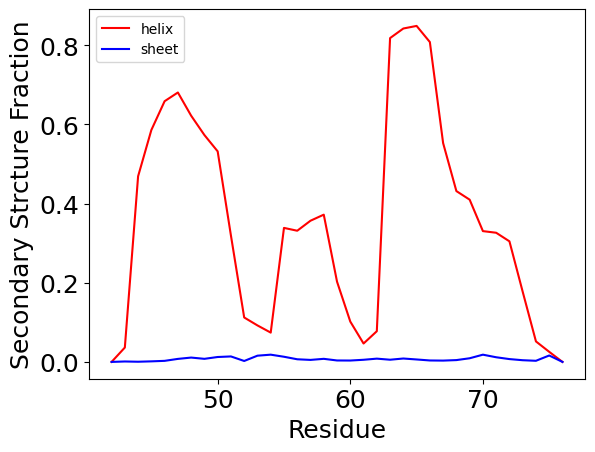

In [54]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
# no sheets, just helices 

In [10]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [11]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [12]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




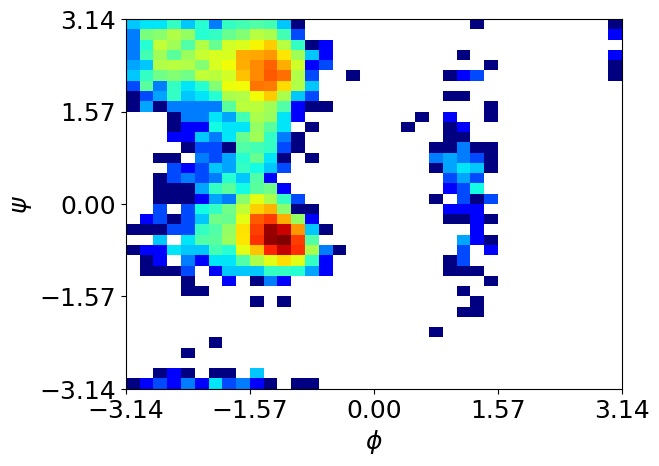

In [13]:
plot_phipsi(70)


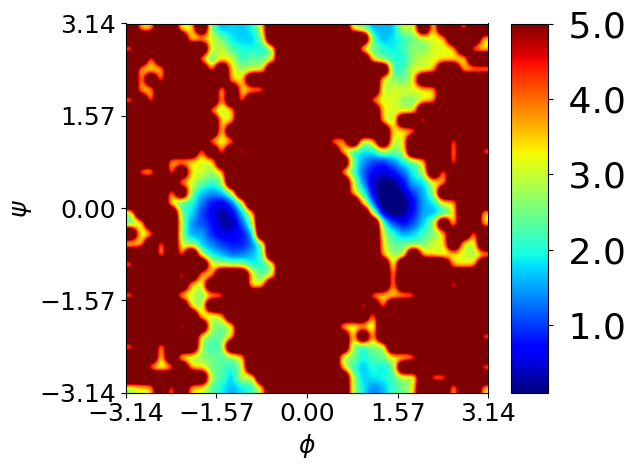

In [14]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

In [16]:
# plot_phipsi(70)
# plt.clf()
# plot_chi(70)

In [12]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [13]:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x14bcaae10>

In [14]:
# grabbing only the CA atoms for our traj :) 
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x14bc9eed0>

### Using RMSD of CA atoms from trajectory to xray pdb to find native and nonnative frames ###

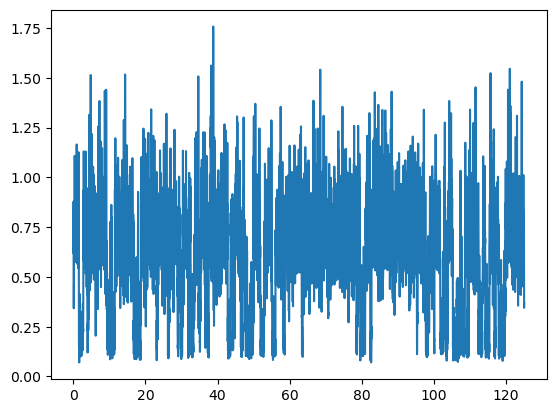

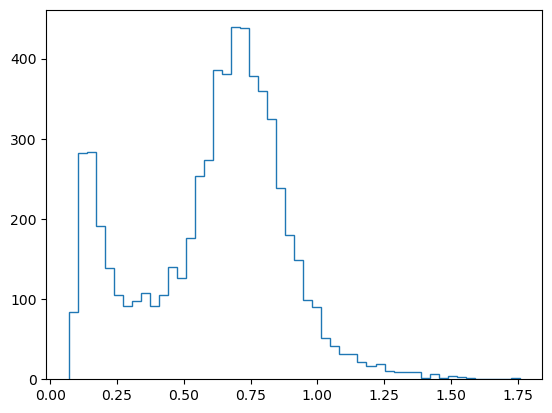

In [15]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")

# look at the rmsd from traj CA to xray 
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()
# at this level of striding, we're not gonna see great transition paths (need the bigger boi to see everything)

RMSD < 0.2 : folded state

RMSD > 0.6 : unfolded state

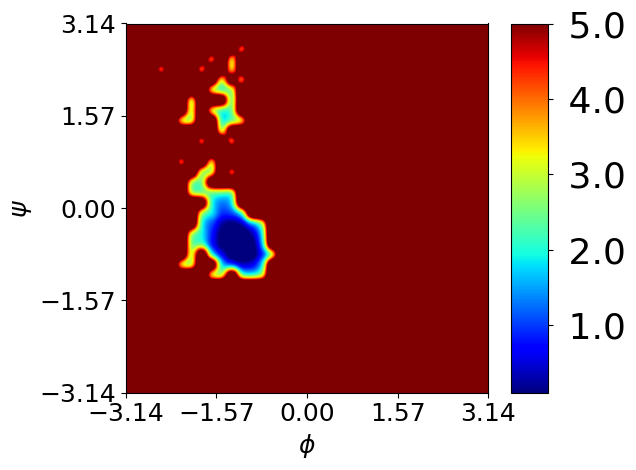

In [16]:
# just look at the native, folded frames

def plot_phipsi_FES_frames(res,frames):
 # plot the free energy for phi and psi for a give set of frames 
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0] # where the RMSD is less than a given threshold 
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(70,native_frames)

# plotting the phi psi free energy for a specific residue for just the frames where the native 
# contacts are intact (<.25nm RMSD from xray structure )


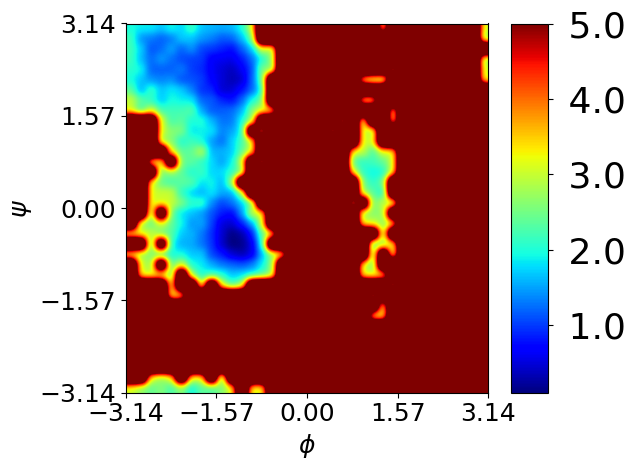

In [17]:
unfolded_frames=np.where(rmsd>0.25)[0] # where the RMSD is greater than a given threshold 
trj[unfolded_frames].save_dcd(outdir+'unfolded.dcd')

plot_phipsi_FES_frames(70,unfolded_frames)
# plotting the phi psi free energy for a specific residue for just the frames where the native 
# contacts has been destroyed! (>.25nm RMSD from xray structure )

Wow, it's different!

### Radius of gyration ###

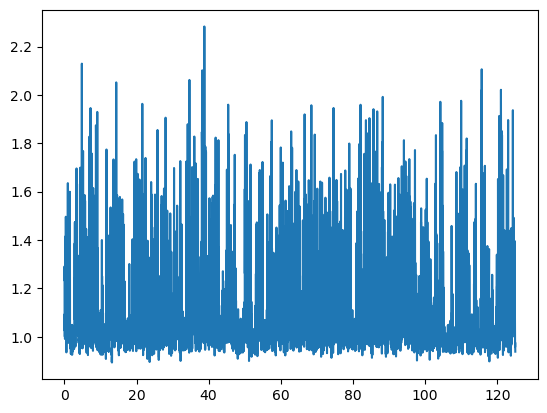

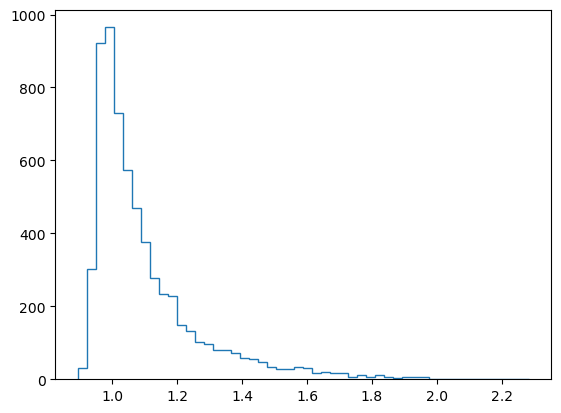

In [58]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

### Calculating the Reaction Coordinates ###
doing PCA with the trajectory's xyz coordinates 

In [70]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


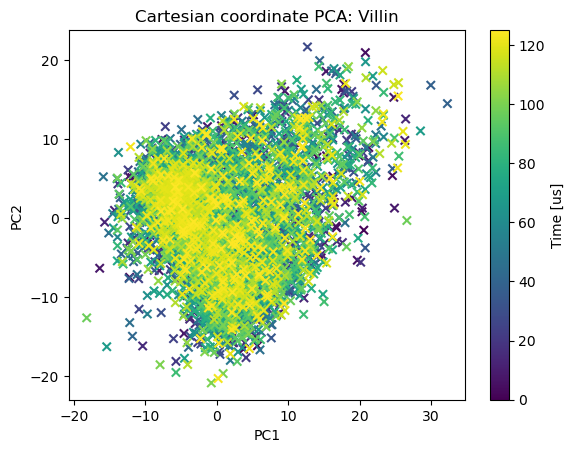

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

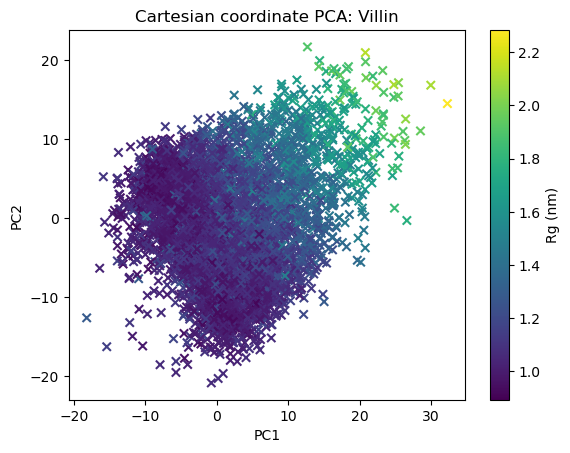

In [27]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

Wow, this looks really nice. We can see that this area of pc space has higher rg, which suggests that this part of pc space corresponds with this unfolded state. 

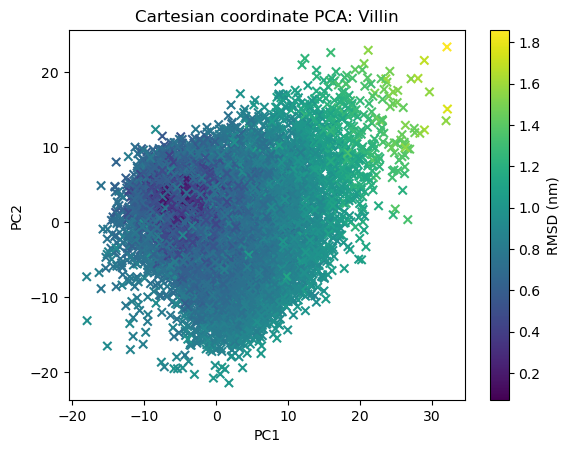

In [32]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

Nice! This agrees with what we saw for the rg plot before, where the rmsd from the xray structure increases in the pc space that also has the increased rg. This also suggests that this unfolded state exists in that part of pc space too. 

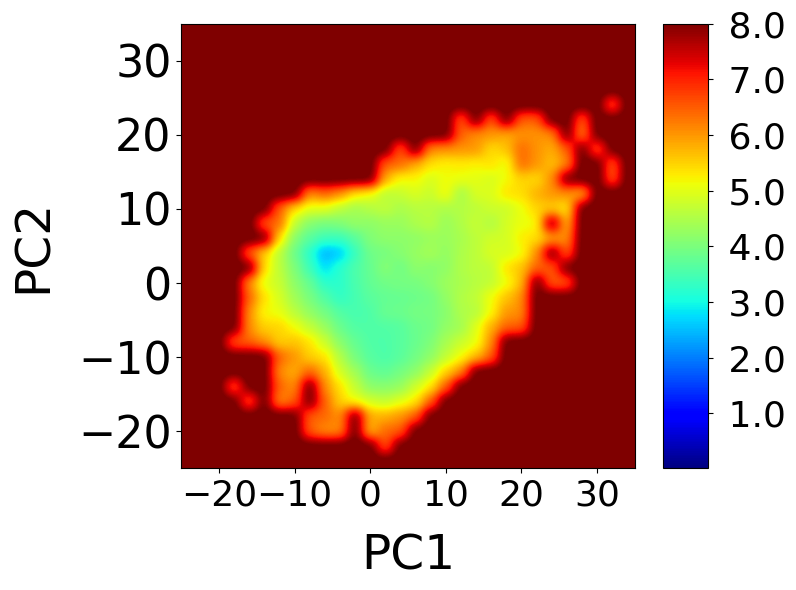

In [34]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

### Classroom Activitiy: Lets plot the free energy as a function of RMSD ###

In [29]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



Text(0, 0.5, 'free energy')

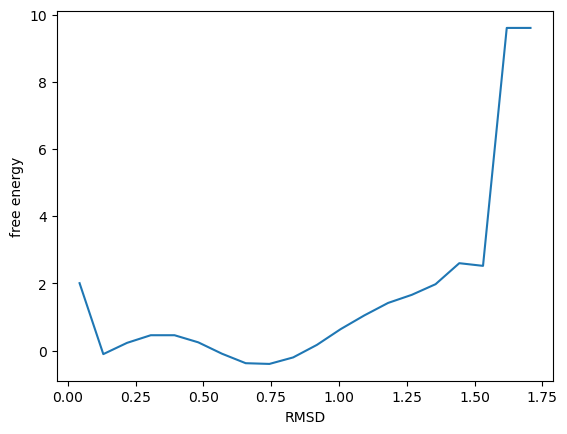

In [30]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)
plt.xlabel('RMSD')
plt.ylabel('free energy')


In [104]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

Text(0, 0.5, 'Free Energy')

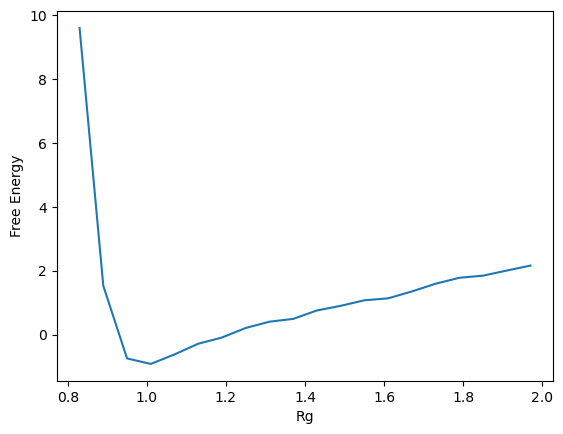

In [31]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)
plt.xlabel('Rg')
plt.ylabel('Free Energy')

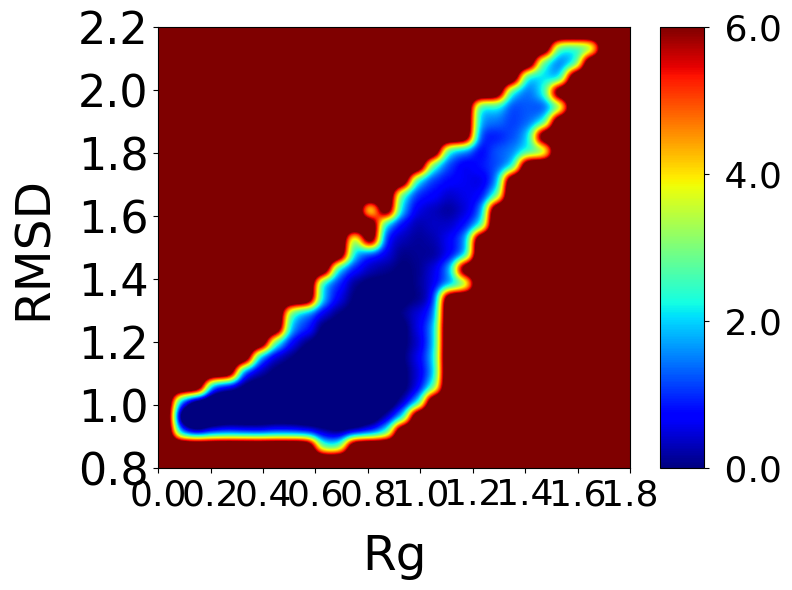

In [41]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

### Dual Residue Contact Calculations ###

In [55]:
import itertools
def product(x:np.ndarray, y:np.ndarray):
    return np.asarray(list(itertools.product(x, y)))


def combinations(x):
    return np.asarray(list(itertools.combinations(x, 2)))

def residue_distances(traj,
                      index_0: np.ndarray,
                      index_1: np.ndarray = None, dist=False):
    """ Brand new distance matrix. the inter case returns a compressed contact probability matrix, 
    but if idx=True, then it will return the whole distance matrix for ya :) """
    # intra distance case
    if index_1 is None:
        indices = combinations(index_0)
        return md.compute_contacts(traj, indices)[0], indices

    # inter distance case
    else:
        indices = product(index_0, index_1)
        if dist == True: 
            return md.compute_contacts(traj, indices)[0]
        else: 
            dist = md.compute_contacts(traj, indices)[0]
            return np.where(dist>.5, 0, 1)

        
def to_distance_matrix(distances: np.ndarray,
                       n: int,
                       m: int = None,
                       d0: int = 1):
    assert (distances.ndim == 2), "Must input a flattened distance array (n,d)"

    # info about flattened distance matrix
    N, d = distances.shape

    # intra molecular distances
    if m is None:
        matrix = np.zeros([N] + [n] * 2)
        i, j = np.triu_indices(n, d0)
        matrix[:, i, j] = distances
        return matrix + matrix.transpose(0, 2, 1)

    else:
        assert d == n * m, \
            "Given dimensions (n,m) do not correspond to the dimension of the flattened distances"

        return distances.reshape(-1, n, m)

In [56]:
dist, idx = residue_distances(trj, np.arange(34))

In [57]:
fixed_dist = to_distance_matrix(dist, 34)

In [58]:
fixed_dist.shape

(6280, 34, 34)

In [59]:
contact=np.where(fixed_dist<0.5, 1, 0)

In [94]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

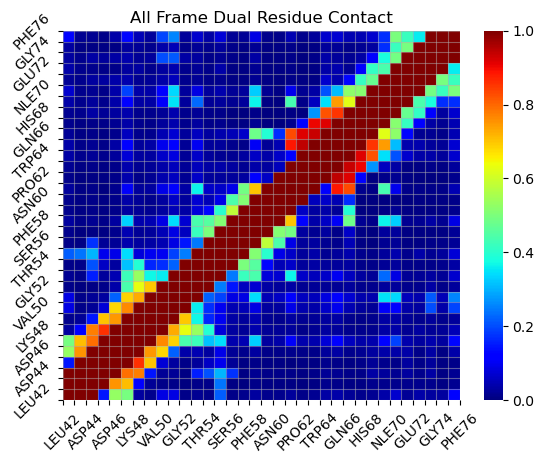

In [106]:
ax = sns.heatmap(contact.mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('All Frame Dual Residue Contact')
plt.show()

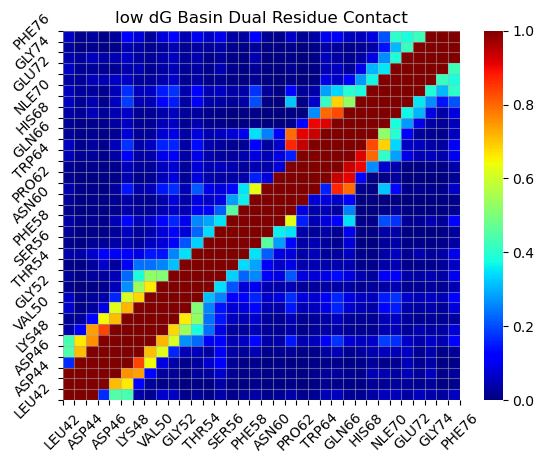

In [108]:
ax = sns.heatmap(contact[basin_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('low dG Basin Dual Residue Contact')
plt.show()

It seems like in this basin we lose the longer distance contacts, and stick to just make this close contacts? 

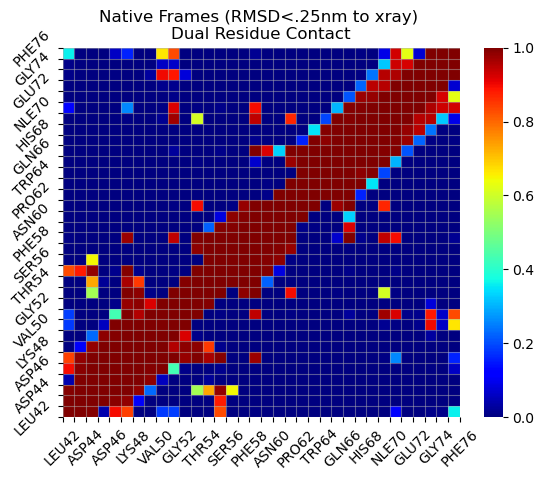

In [110]:
ax = sns.heatmap(contact[native_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Native Frames (RMSD<.25nm to xray) \nDual Residue Contact')
plt.show()

This looks so weird! These are the frames that are closest to the native frames. It makes sense that the close contacts are locked in, and other contacts that exist are almost always there (>0.8 contact probability over all frames)

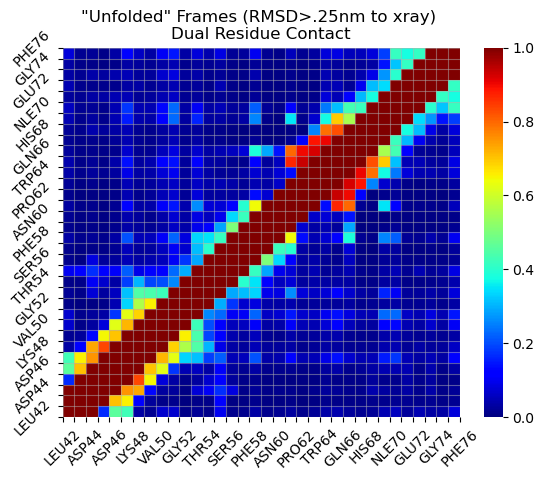

In [111]:
ax = sns.heatmap(contact[unfolded_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('"Unfolded" Frames (RMSD>.25nm to xray) \nDual Residue Contact')
plt.show()

Yeah! This is what we saw in the dG basin from before. interesting that even this unfolded state seems to have contacts that it prefers to make. 

### Circular Mean ###

In [112]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [113]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)

In [114]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

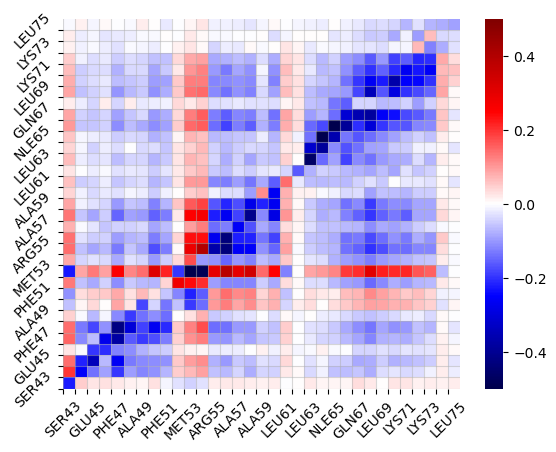

In [115]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

### Trying now to find native contacts, Q and these transition paths ###

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

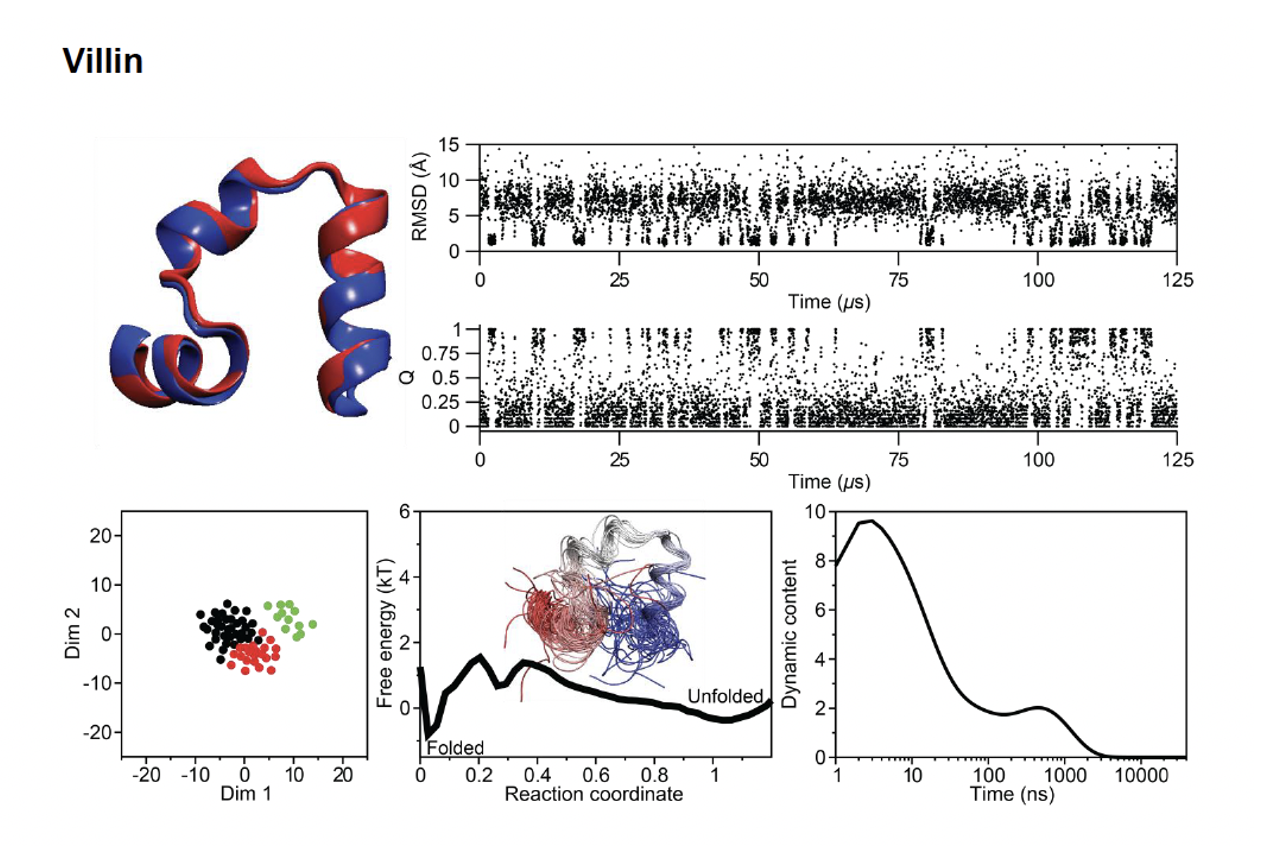

First we need to determine the native contacts and calculate Q

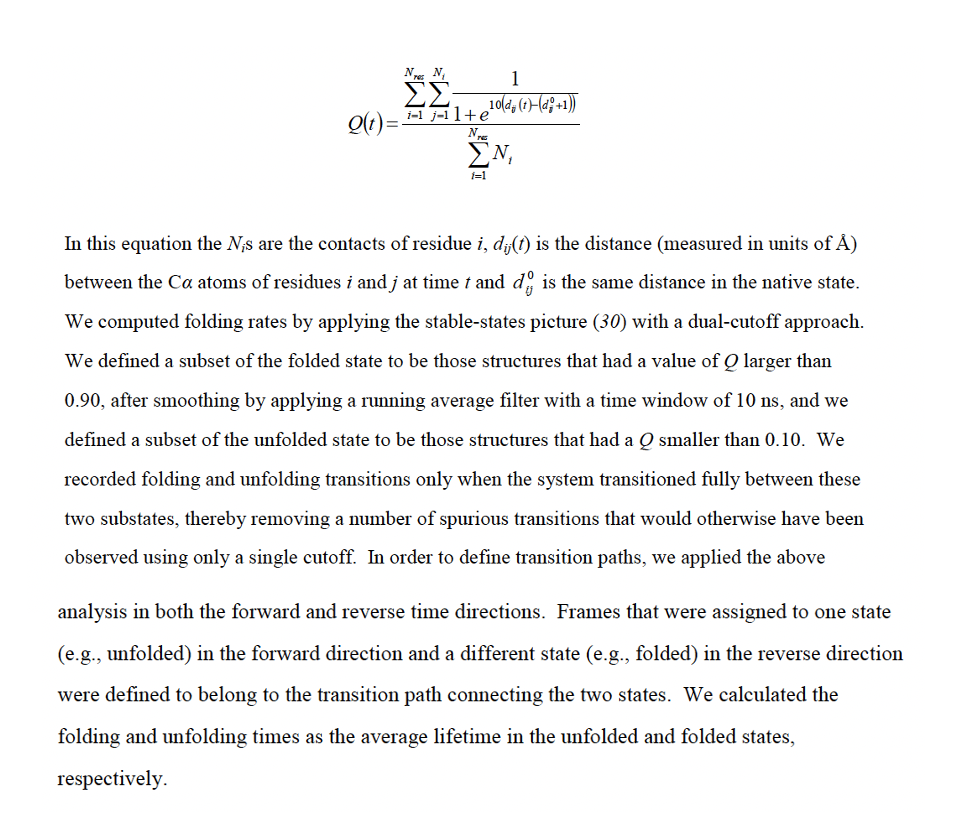

In [18]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x14bcaae10>

In [19]:
# FOR THE XRAY STRUCTURE
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
   # Looking only at long distance contacts, which was defined as 7 residues away in the paper
  if(abs(i-j)>7):
   #print(i,j)
   dist1=md.compute_distances(xray_CA,[[i,j]])[0][0]
   # everytime we have a contact, we'll add that distance 
   native_distance_matrix1D.append(dist1)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [20]:
native_distance_matrix1D.shape

(702,)

In [21]:
native_distance_matrix1D.shape

(702,)

In [22]:
# defining contacts where the distance is less than 10 Angstroms 
native_idx=np.where(native_distance_matrix1D<10) 
Native_Contact_Distances=native_distance_matrix1D[native_idx]
np.shape(Native_Contact_Distances) # the amount of long distance native contacts we have

(148,)

In [23]:
# Now doing the same for the trajectory's CA atoms 
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7): # if long distance contact
   dist=md.compute_distances(trjCA,[[i,j]])[:,0] # compute distance
   traj_CA_distance_matrix1D.append(dist) # add it to the list! 

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
# pulling out the CA distances where we found the native contacts  
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[native_idx] 


In [21]:
trj.n_frames

6280

In [42]:
# we get a distance for each frame for these original long-distance native contacts found from the xray 
Traj_Native_Contact_Distances.shape

(148, 6280)

In [43]:
# Now we can sort of visually compare the native dist in the xray 
# vs the trajectory average distance between this native contact 
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i].mean())

9.288557 13.622647
9.985726 16.43719
9.704253 15.123908
9.60349 12.762021
7.0967283 12.718798
7.0852814 13.380732
9.99271 14.831583
9.574567 11.926988
8.303897 12.24485
9.653462 13.321598
9.792494 14.908245
9.633482 11.922619
7.2052145 14.541401
9.064561 16.456821
9.7293 17.39743
6.8318415 11.116647
9.636899 12.85215
9.7255125 13.30054
9.826442 14.610104
9.577069 15.540217
9.702944 12.445333
9.78856 12.856949
9.638851 13.270845
9.2830715 15.632019
7.1804132 13.317078
9.596453 13.681862
7.6731033 15.234544
6.4531145 16.153326
9.288557 13.622647
8.5293255 12.843365
5.5412273 14.384824
4.347249 15.280936
7.9513245 14.469658
9.684021 15.897119
9.701723 14.280736
9.797035 14.181551
7.3131294 15.601464
9.571478 15.678847
8.860846 13.142524
6.506905 14.016895
9.469033 13.260776
9.927504 13.6829405
7.4795647 13.722557
8.667387 13.872618
9.772589 15.785737
7.7988334 15.631148
7.810409 14.011748
9.60349 12.762021
9.574567 11.926988
7.0967283 12.718798
8.303897 12.24485
9.633482 11.922619
9.98572

In [24]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
 Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

In [45]:
Native_Contact_Distances_nframes.shape

(148, 6280)

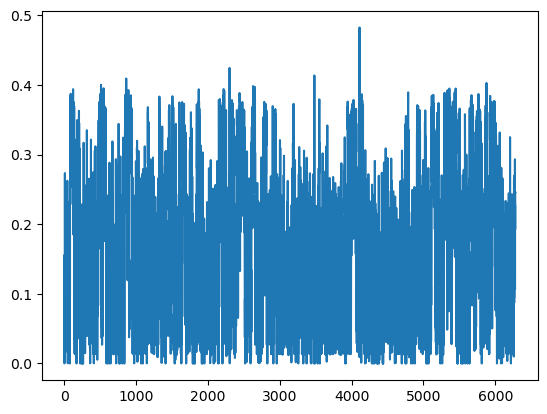

(array([1.087e+03, 1.503e+03, 9.610e+02, 6.850e+02, 4.700e+02, 4.940e+02,
        5.690e+02, 4.810e+02, 2.900e+01, 1.000e+00]),
 array([1.28075769e-25, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x14bbf1c10>])

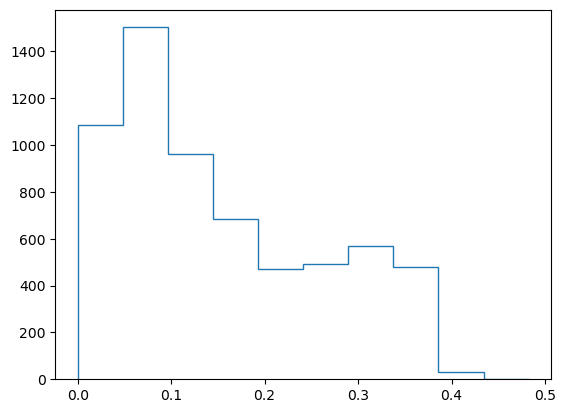

In [25]:
# Now, here's the calculation for the part func Q that was given in the paper! 
# they define Q(t) as reaction coordinates actually, pretty cool! 
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [26]:
# Now Lets Consider the "Native Portion of the Trajectory" where 
# RMSD to xray is <.25nm
native_frames.shape

(1016,)

In [27]:
native_distance_matrix1D.shape

(702,)

In [28]:
traj_CA_distance_matrix1D.shape

(702, 6280)

In [29]:
# only grabbing those frames where the RMSD <.25nm
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
trj_native_distances.shape

(702, 1016)

In [30]:
# Averaging across all trajectory frames 
averages=trj_native_distances.mean(1)
# Now, saying we have a native long distance contact when the distance is below 10 angstroms
# and grabbing those indices for the long native contact 
native_idx=np.where(averages<10.0)[0]
native_idx 
# so these are the indices of the long range CA distances that on average form native contacts similar to the xray, 
# who also lie only in the native frames only. 
# Wow, this is getting so confusing. 

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 550, 557,
       569, 570, 635, 636, 684])

In [31]:
# Pulling out the contacts from the xray
Native_CA_Distances=native_distance_matrix1D[native_idx]

# pulling out the contacts from the trajectory 
Traj_CA_Distances=traj_CA_distance_matrix1D[native_idx]

# Expand Native Distance Matrix so that its the same number of frames as the trajectory
# (we've done this before but just in case im losing track of these variables)
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distances))
for i in range(0,len(Native_CA_Distances)):
    Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(44, 6280)

In [32]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distances[i].mean())

9.985726 16.43719
10.452459 14.803059
9.704253 15.123908
9.60349 12.762021
7.0967283 12.718798
7.0852814 13.380732
9.99271 14.831583
9.574567 11.926988
8.303897 12.24485
9.653462 13.321598
9.633482 11.922619
10.225195 12.814175
6.8318415 11.116647
9.7255125 13.30054
9.797035 14.181551
7.3131294 15.601464
9.571478 15.678847
7.4795647 13.722557
8.667388 13.872618
7.7988334 15.631148
9.60349 12.762021
9.574567 11.926988
10.452459 14.803059
7.0967283 12.718798
8.303897 12.24485
9.633482 11.922619
9.985726 16.43719
9.704253 15.123908
7.0852814 13.380732
9.653462 13.321598
10.225195 12.814175
6.8318415 11.116647
9.99271 14.831583
9.7255125 13.30054
6.6416473 10.513765
9.298402 13.762217
6.6416473 10.513765
7.4795647 13.722557
9.298402 13.762217
9.797035 14.181551
8.667388 13.872618
7.3131294 15.601464
7.7988334 15.631148
9.571478 15.678847


In [33]:
# Ok, it seems like Q is the reaction coordinate for every given frame. 
# And that it is related to the distances between the long range native contacts 
# formed in the xray and as seen for only the native frames for the trajectory. 
Q.shape

(6280,)

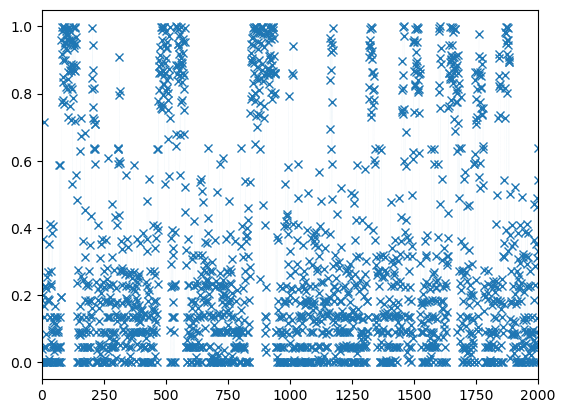

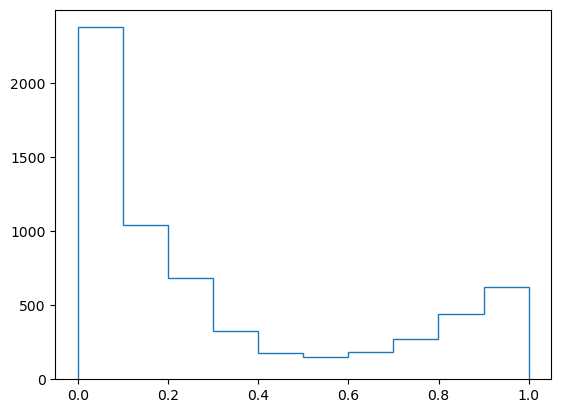

In [34]:
# So now, let's attempt to plot these reaction coordinates...
# Calculating Q from our trajectory native contacts and our xray native contacts
Q=1/(1+np.exp(10*(Traj_CA_Distances-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)

# Now, plotting Q along our frames (Q(t) ?)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000) # zooming in until frame 2000 
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

Text(0, 0.5, 'Q')

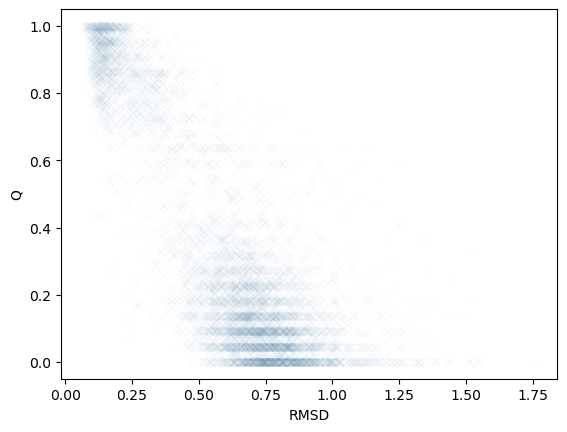

In [35]:
# Seems like there are two different Q states!
# Let's plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)
plt.xlabel('RMSD')
plt.ylabel("Q")

Okay, this kind of makes it more clear to me! It seems that the reaction coordinate around 0.8-1.0 describes the folded state, whereas the reaction coordinate <0.3 describes the unfolded state we observe when the RMSD from the xray structure becomes high. 

THIS MAKES SENSE. Q is defined to be proportional to the difference in distances of native contacts for the trajectory and for the xray structure. The more similar they are, the more likely Q is going to go to 1. And the more different they are, the more likely Q will go to 0. 

Text(0, 0.5, 'Q')

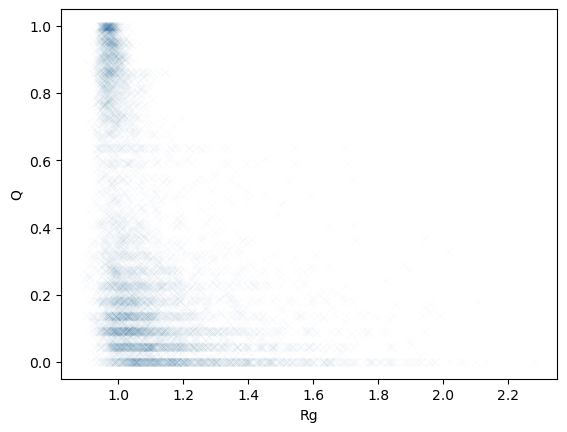

In [59]:
#Plot Q and a Histogram
plt.scatter(rg,Q,marker='x',linewidth=.01)
plt.xlabel('Rg')
plt.ylabel("Q")

It's a little less apparent with Rg, but you can still see the smear of larger Rg values for these lower Q values, which supports the earlier assertion. 

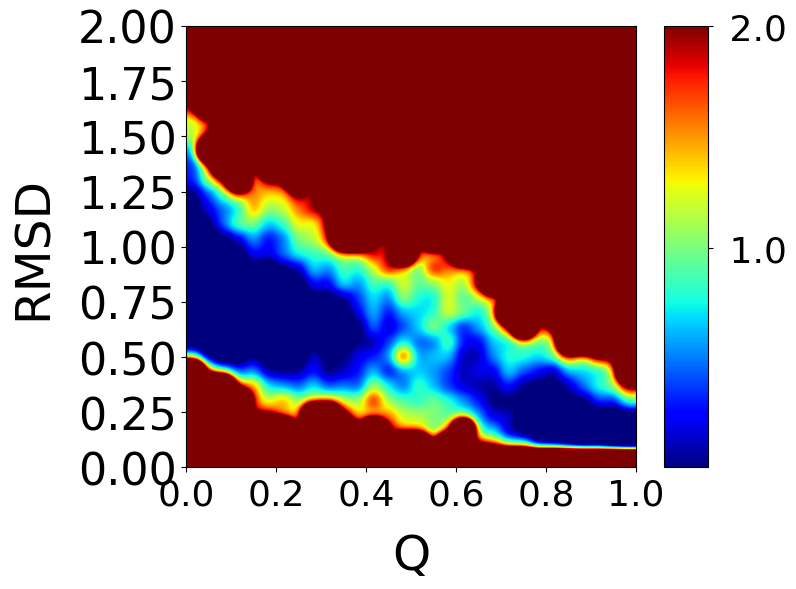

In [116]:
# Now, turning it into a nice free energy plot 
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

Text(0, 0.5, '$\\Delta$G')

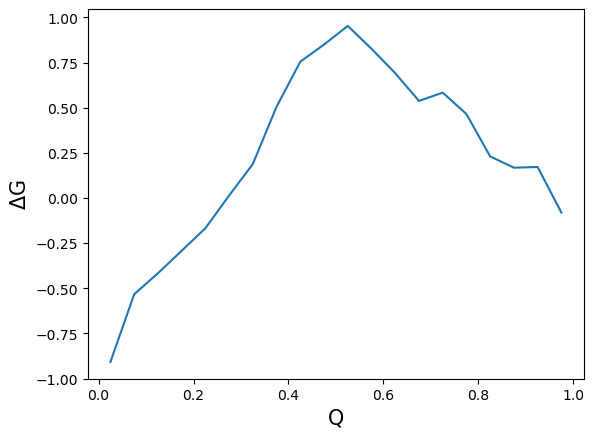

In [117]:
# Now, attempting to associate a free energy with this reaction coordinate!
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

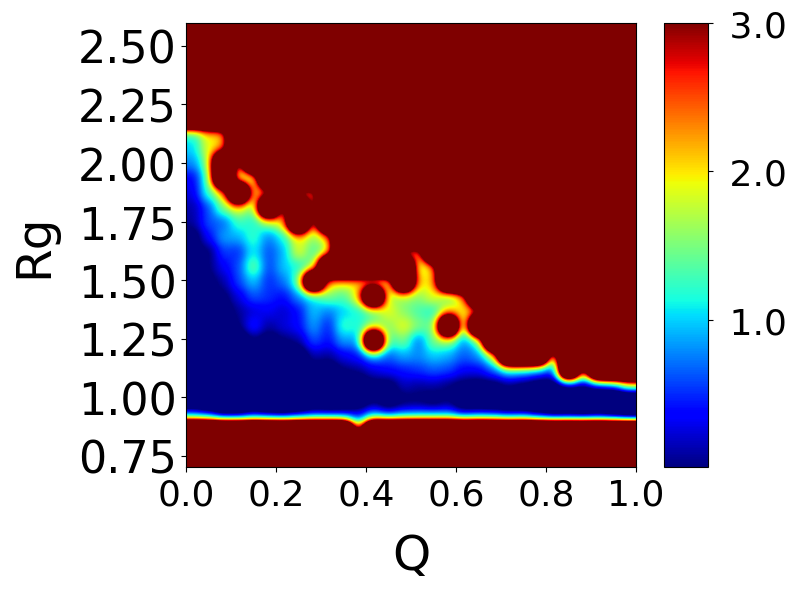

In [118]:
# Now plotting the free energy of Rg by Q
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

I feel like this captures the spirit more than the plot before! We see this smear of larger Rg values when the Q becomes smaller. 

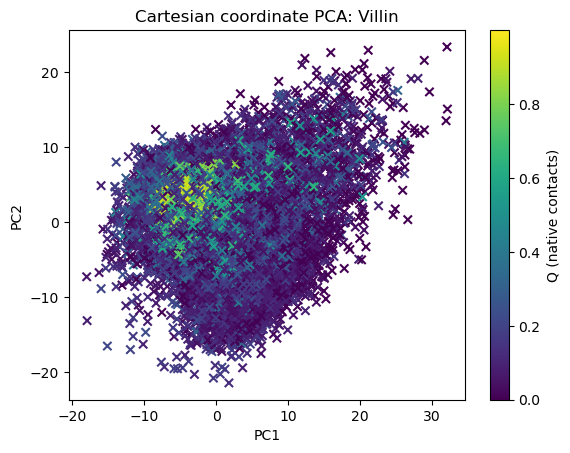

In [119]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

Interesting that our higher Q population is nestled in here. I feel like this really shows that this Q is only really calculated for our native frames of the trajectory that we saw before. 

In [ ]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

In [ ]:
#Select Only the Frames with low RMSD from native state for the native distances


In [ ]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 


In [ ]:
#Check that we're comparing all the correct distances 


In [ ]:
#Plot Q using only our native frames


### Lets Calculate Our Transition Paths using the Dual Cutoff Approach ###
*"We defined a subset of the folded state to be those structures that had a value of Q larger than 0.90, after smoothing by applying a running average filter with a time window of 10 ns, and we defined a subset of the unfolded state to be those structures that had a Q smaller than 0.10. We recorded folding and unfolding transitions only when the system transitioned fully between these two substates, thereby removing a number of spurious transitions that would otherwise have been observed using only a single cutoff."*

*"In order to define transition paths, we applied the above analysis in both the forward and reverse time directions. Frames that were assigned to one state (e.g., unfolded) in the forward direction and a different state (e.g., folded) in the reverse direction were defined to belong to the transition path connecting the two states. We calculated the folding and unfolding times as the average lifetime in the unfolded and folded states, respectively."*

 you know, i must be overthinking this! They really turned me around though when they said that the transition states needed to fully transition between these two Q values. I'm not really sure how to comput e that, so i might do it by hand once to see if i'm getting thte right idea? 


In [69]:
# Now, I'm not sure if I'm understanding them correctly, but I can at least try, right?
Q.shape

(6280,)

In [ ]:
# So we have a reaction coordinate for each frame. They said Q<0.1 unfolded and Q>0.9 folded, 
#so let's try grabbing those frames
folded_idx = np.where(Q>0.9)
unfolded_idx = np.where(Q<0.1)

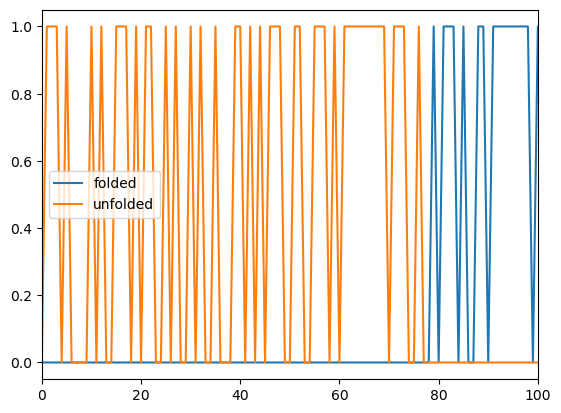

In [61]:
plt.plot(np.arange(trj.n_frames),np.where(Q>0.9, 1, 0), label='folded')
plt.plot(np.arange(trj.n_frames), np.where(Q<0.1, 1, 0), label='unfolded')
plt.xlim(0,100)
plt.legend()

So, the idea here is that the transition path occurs at frame ~77, because the switch over does occur until there. 

The real question is, how would i code this to find these intervals...?

In [38]:
# let 1 == unfolded
# let 2 == folded 
# let 0 be undefined 
idx1 = np.where(Q>.9, 2, 0)
idx2 = np.where(Q<.1, 1, 0)
binary = idx1+idx2

In [39]:
np.where(binary!=0)

(array([   1,    2,    3, ..., 6262, 6263, 6275]),)

In [40]:
no_zeros = binary[binary!=0]

turning_point = []
for i,bin in enumerate(no_zeros):
    old_state = no_zeros[i-1]
    if bin == 1: 
        new_state = 1
        if new_state != old_state: 
            turning_point.append(i)
    if bin ==2: 
        new_state = 2
        if new_state != old_state: 
            turning_point.append(i)


In [41]:
# Now!! We're getting back the frames where these switches occur. I guess the only thing now is to do it backwards 
# to get the full ranges of transition paths! 
np.where(binary!=0)[0][np.array(turning_point)]

array([  79,  142,  203,  217,  313,  317,  476,  517,  542,  581,  843,
        900,  906,  943, 1012, 1014, 1162, 1176, 1319, 1351, 1456, 1465,
       1498, 1528, 1601, 1610, 1640, 1676, 1680, 1688, 1762, 1786, 1843,
       1850, 1869, 1889, 2151, 2193, 2218, 2236, 2251, 2253, 2334, 2363,
       2400, 2512, 2610, 2658, 2770, 2816, 2923, 2950, 3187, 3195, 3550,
       3554, 3944, 3967, 3998, 4069, 4135, 4156, 4744, 4749, 4786, 4799,
       4914, 4928, 4929, 4943, 4949, 4958, 5025, 5032, 5112, 5165, 5192,
       5218, 5288, 5331, 5332, 5353, 5355, 5391, 5405, 5456, 5488, 5513,
       5643, 5708, 5739, 5796, 5863, 5884, 5922, 6022])

In [42]:
trans_end = np.where(binary!=0)[0][np.array(turning_point)]

In [43]:
# doing it backwards now??
no_zeros = np.flip(binary[binary!=0])

turning_point = []
for i,bin in enumerate(no_zeros):
    old_state = no_zeros[i-1]
    if bin == 1: 
        new_state = 1
        if new_state != old_state: 
            turning_point.append(i)
    if bin ==2: 
        new_state = 2
        if new_state != old_state: 
            turning_point.append(i)


In [44]:
np.flip(np.flip(np.where(binary!=0)[0])[np.array(turning_point)])

array([  76,  137,  194,  205,  298,  313,  464,  515,  535,  577,  836,
        895,  902,  936, 1008, 1012, 1159, 1173, 1316, 1332, 1444, 1462,
       1495, 1516, 1597, 1609, 1631, 1669, 1676, 1680, 1759, 1773, 1840,
       1844, 1859, 1884, 2149, 2188, 2217, 2228, 2248, 2251, 2328, 2358,
       2393, 2504, 2604, 2654, 2763, 2813, 2920, 2945, 3178, 3194, 3545,
       3550, 3941, 3963, 3991, 4064, 4134, 4151, 4739, 4744, 4783, 4794,
       4903, 4927, 4928, 4939, 4945, 4952, 5015, 5027, 5106, 5162, 5188,
       5213, 5285, 5330, 5331, 5345, 5353, 5386, 5392, 5451, 5481, 5504,
       5639, 5691, 5733, 5790, 5854, 5883, 5920, 6011])

In [45]:
trans_start = np.flip(np.flip(np.where(binary!=0)[0])[np.array(turning_point)])

In [46]:
# Now, let's just double check that this is legit
# checking to see if this 76 --> 79 is infact a transition as defined in the paper
binary[70:80]
# Holy shit, I did it!

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 2])

In [47]:
# Let's look at all of these babies now!!! This is so exciting!!
for i,j in zip(trans_start, trans_end): 
    print(i, j)
    print('----')

76 79
----
137 142
----
194 203
----
205 217
----
298 313
----
313 317
----
464 476
----
515 517
----
535 542
----
577 581
----
836 843
----
895 900
----
902 906
----
936 943
----
1008 1012
----
1012 1014
----
1159 1162
----
1173 1176
----
1316 1319
----
1332 1351
----
1444 1456
----
1462 1465
----
1495 1498
----
1516 1528
----
1597 1601
----
1609 1610
----
1631 1640
----
1669 1676
----
1676 1680
----
1680 1688
----
1759 1762
----
1773 1786
----
1840 1843
----
1844 1850
----
1859 1869
----
1884 1889
----
2149 2151
----
2188 2193
----
2217 2218
----
2228 2236
----
2248 2251
----
2251 2253
----
2328 2334
----
2358 2363
----
2393 2400
----
2504 2512
----
2604 2610
----
2654 2658
----
2763 2770
----
2813 2816
----
2920 2923
----
2945 2950
----
3178 3187
----
3194 3195
----
3545 3550
----
3550 3554
----
3941 3944
----
3963 3967
----
3991 3998
----
4064 4069
----
4134 4135
----
4151 4156
----
4739 4744
----
4744 4749
----
4783 4786
----
4794 4799
----
4903 4914
----
4927 4928
----
4928 4929


In [50]:
# now getting all of our transition path frames...
tp_idx = []
for i,j in zip(trans_start, trans_end): 
    tp_idx.append(np.arange(i+1,j))
trpt_idx = np.concatenate(tp_idx)

In [51]:
trpt_idx

array([  77,   78,  138,  139,  140,  141,  195,  196,  197,  198,  199,
        200,  201,  202,  206,  207,  208,  209,  210,  211,  212,  213,
        214,  215,  216,  299,  300,  301,  302,  303,  304,  305,  306,
        307,  308,  309,  310,  311,  312,  314,  315,  316,  465,  466,
        467,  468,  469,  470,  471,  472,  473,  474,  475,  516,  536,
        537,  538,  539,  540,  541,  578,  579,  580,  837,  838,  839,
        840,  841,  842,  896,  897,  898,  899,  903,  904,  905,  937,
        938,  939,  940,  941,  942, 1009, 1010, 1011, 1013, 1160, 1161,
       1174, 1175, 1317, 1318, 1333, 1334, 1335, 1336, 1337, 1338, 1339,
       1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350,
       1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455,
       1463, 1464, 1496, 1497, 1517, 1518, 1519, 1520, 1521, 1522, 1523,
       1524, 1525, 1526, 1527, 1598, 1599, 1600, 1632, 1633, 1634, 1635,
       1636, 1637, 1638, 1639, 1670, 1671, 1672, 16

Now, let's look at some characteristics of the transition path and see how they differ from the folded and unfolded states!!

Text(0.5, 1.0, 'Folded frames (Q>.9) dssp')

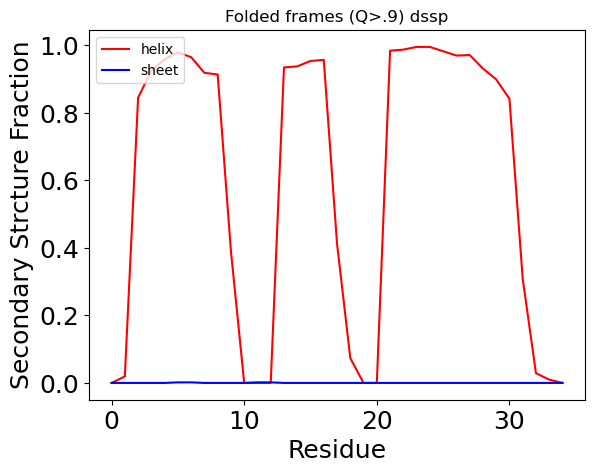

In [60]:
Hprop,Eprop=dssp_convert(dssp[folded_idx])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Folded frames (Q>.9) dssp')

Text(0.5, 1.0, 'Transition path dssp')

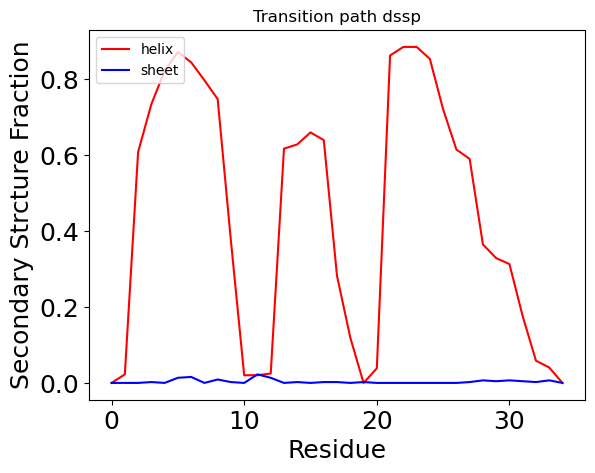

In [61]:
Hprop,Eprop=dssp_convert(dssp[trpt_idx])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Transition path dssp')

Text(0.5, 1.0, 'Unfolded frames (Q<.1) dssp')

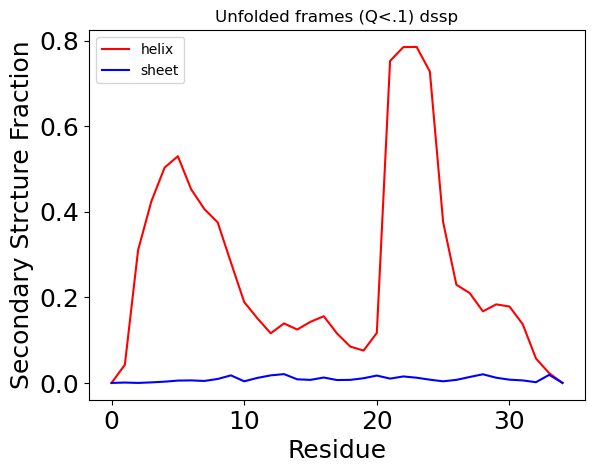

In [62]:
Hprop,Eprop=dssp_convert(dssp[unfolded_idx])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Unfolded frames (Q<.1) dssp')

This is huge! We see the deterioration of these helices from the folded to the transition state to the unfolded state, which is what we'd expect. I'm surprised about how well maintained some of these helices are during these transition states though. For example, we only see the complete collapse of that middle helix in the unfolded state, whereas during the transition state it seems to be very much there (although a bit less than in the folded state). The drop off of the last helix seems to be pretty consistent between the transition state and the unfolded state, where you can evidentally see the collapse of those c-terminal residues of that helix. 

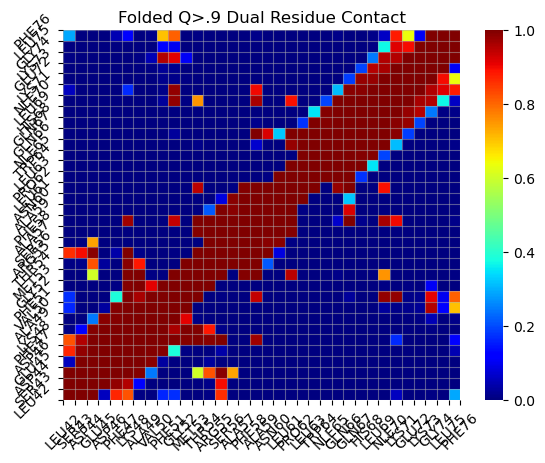

In [66]:
# now, we can check out the dual residue contacts! 
ax = sns.heatmap(contact[folded_idx].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Folded Q>.9 Dual Residue Contact')
plt.show()

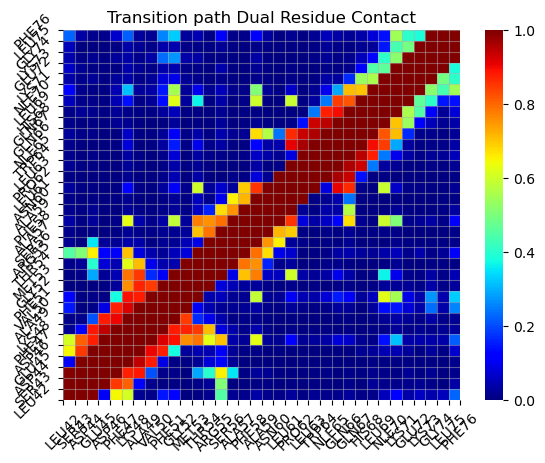

In [65]:
# now, we can check out the dual residue contacts! 
ax = sns.heatmap(contact[trpt_idx].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Transition path Dual Residue Contact')
plt.show()

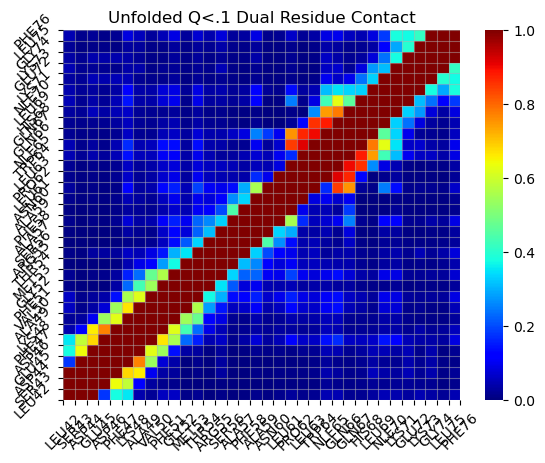

In [68]:
# now, we can check out the dual residue contacts! 
ax = sns.heatmap(contact[unfolded_idx].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Unfolded Q<.1 Dual Residue Contact')
plt.show()

This is also super cool! We begin to see the deterioration of those very specific high probability contacts from the folded state in the transition state. We begin to see the formation of these close intraresidue contacts in the transition state that we observe in the unfolded state while still preserving some of the structured contacts from the folded state, albeit (albethem?) at a lower probability. 

That area from residue 45-55 seems a little bit fiery in that transition state; I think as that helix is breaking during that transition state its causing a lot of contacts, but then as it goes to the unfolded state it cools down a little bit and those contacts are lost. 

You can see that the middle helix that was there in that transition state is also completely destroyed in that unfolded state, but that last helix somehow survives the transition state and the unfolded state (although it gets a bit smaller).

This is really cool how we can see the transition from folded to unfolded with this intermediate state that we got from Q!

In [71]:
# Lastly, i wonder if we can project these different frames onto our 
# pc space and see if they cluster nicely (long shot)
reduced_cartesian[:, 0].shape

(6280,)

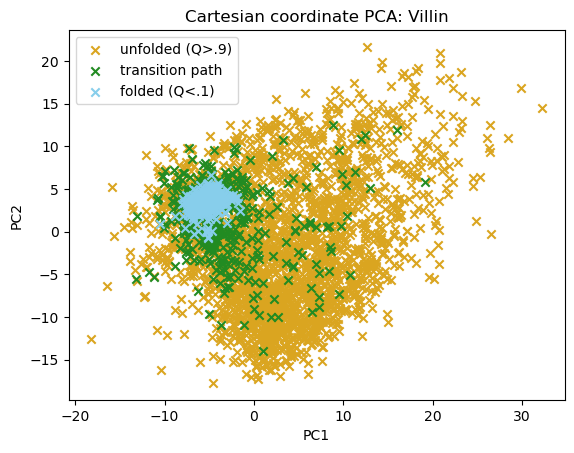

In [74]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0][unfolded_idx], reduced_cartesian[:,1][unfolded_idx], 
            marker='x', c='goldenrod', label='unfolded (Q>.9)')
plt.scatter(reduced_cartesian[:, 0][trpt_idx], reduced_cartesian[:,1][trpt_idx], marker='x', c='forestgreen', label='transition path')
plt.scatter(reduced_cartesian[:, 0][folded_idx], reduced_cartesian[:,1][folded_idx], marker='x', c='skyblue',label='folded (Q<.1)')
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
plt.legend()
# cbar = plt.colorbar()
# cbar.set_label('Time [us]')

Okay, this is sick. You can see how the folded state takes up this cute little small pc space, where the coordinates seemed to not be varying all that much. This spread increases during the transition path, and just increases as we get to the unfolded state. This seems to be the true progression we were hoping for! I'm so glad!